In [8]:
'''
IMPORTS
'''

import numpy as np 
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [9]:
'''
PREPROCESSING
'''

M = fetch_openml(data_id=24)
x, y = M.data, M.target

#! Convert the data to a pandas DataFrame
M_features_df = pd.DataFrame(x, columns=M.feature_names)
M_targets_df = pd.DataFrame(y, columns=['class'])

M_everything_df = pd.concat([M_features_df, M_targets_df], axis=1)
# print(M_everything_df.head())

'''
CONVERT TO NUMERICAL DATA
'''
mapping = {
    'cap-shape': {'b': 0, 'c': 1, 'x': 2, 'f': 3, 'k': 4, 's': 5},
    'cap-surface': {'f': 0, 'g': 1, 'y': 2, 's': 3},
    'cap-color': {'n': 0, 'b': 1, 'c': 2, 'g': 3, 'r': 4, 'p': 5, 'u': 6, 'e': 7, 'w': 8, 'y': 9},
    'bruises%3F': {'f': 0, 't': 1},
    'odor': {'a': 0, 'l': 1, 'c': 2, 'y': 3, 'f': 4, 'm': 5, 'n': 6, 'p': 7, 's': 8},
    'gill-attachment': {'a': 0, 'd': 1, 'f': 2, 'n': 3},
    'gill-spacing': {'c': 0, 'w': 1, 'd': 2},
    'gill-size': {'b': 0, 'n': 1},
    'gill-color': {'k': 0, 'n': 1, 'b': 2, 'h': 3, 'g': 4, 'r': 5, 'o': 6, 'p': 7, 'u': 8, 'e': 9, 'w': 10, 'y': 11},
    'stalk-shape': {'e': 0, 't': 1},
    'stalk-root': {'b': 0, 'c': 1, 'u': 2, 'e': 3, 'z': 4, 'r': 5, '?': 6},
    'stalk-surface-above-ring': {'f': 0, 'y': 1, 'k': 2, 's': 3},
    'stalk-surface-below-ring': {'f': 0, 'y': 1, 'k': 2, 's': 3},
    'stalk-color-above-ring': {'n': 0, 'b': 1, 'c': 2, 'g': 3, 'o': 4, 'p': 5, 'e': 6, 'w': 7, 'y': 8},
    'stalk-color-below-ring': {'n': 0, 'b': 1, 'c': 2, 'g': 3, 'o': 4, 'p': 5, 'e': 6, 'w': 7, 'y': 8},
    'veil-type': {'p': 0, 'u': 1},
    'veil-color': {'n': 0, 'o': 1, 'w': 2, 'y': 3},
    'ring-number': {'n': 0, 'o': 1, 't': 2},
    'ring-type': {'c': 0, 'e': 1, 'f': 2, 'l': 3, 'n': 4, 'p': 5, 's': 6, 'z': 7},
    'spore-print-color': {'k': 0, 'n': 1, 'b': 2, 'h': 3, 'r': 4, 'o': 5, 'u': 6, 'w': 7, 'y': 8},
    'population': {'a': 0, 'c': 1, 'n': 2, 's': 3, 'v': 4, 'y': 5},
    'habitat': {'g': 0, 'l': 1, 'm': 2, 'p': 3, 'u': 4, 'w': 5, 'd': 6},
    'class': {'e': 0, 'p': 1}
}
for column, mp in mapping.items():
    M_everything_df[column] = M_everything_df[column].replace(mp)
# print(M_everything_df.head())

le = LabelEncoder()
M_everything_df_encoded = M_everything_df.apply(le.fit_transform)

'''
CLEAN DATA; VERIFY WITH STANDARD DEVIATION AND MEAN
'''

# veil-type has std = mean = 0 
# remove veil-type column
M_everything_df_encoded = M_everything_df_encoded.drop(columns='veil-type')

# change to 1 to see std/mean outputs
if(0):
    print("standard deviations:")
    std = M_everything_df_encoded.std()
    print(std)
    print()
    print("mean:")
    mean = M_everything_df_encoded.mean()
    print(mean)

'''
SPLIT DATA
'''
# Now split and use the encoded DataFrame
train, test = train_test_split(M_everything_df_encoded, test_size=.2, random_state=41)

X_train = train.iloc[:,:-1].values
Y_train = train.iloc[:,-1].values

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values

<AxesSubplot: xlabel='cap-color', ylabel='Count'>

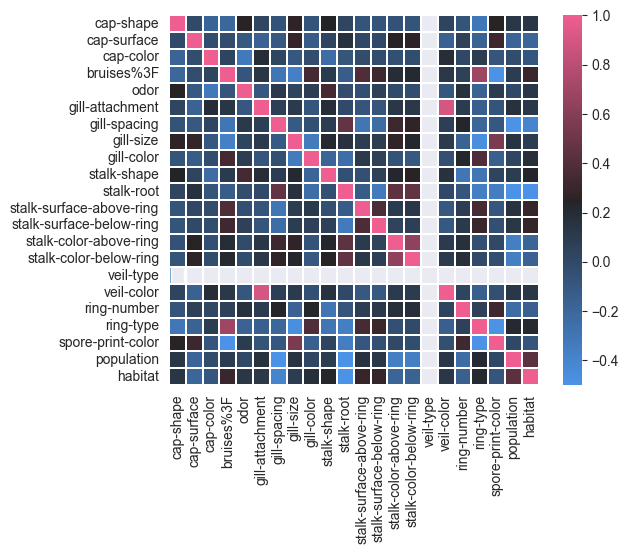

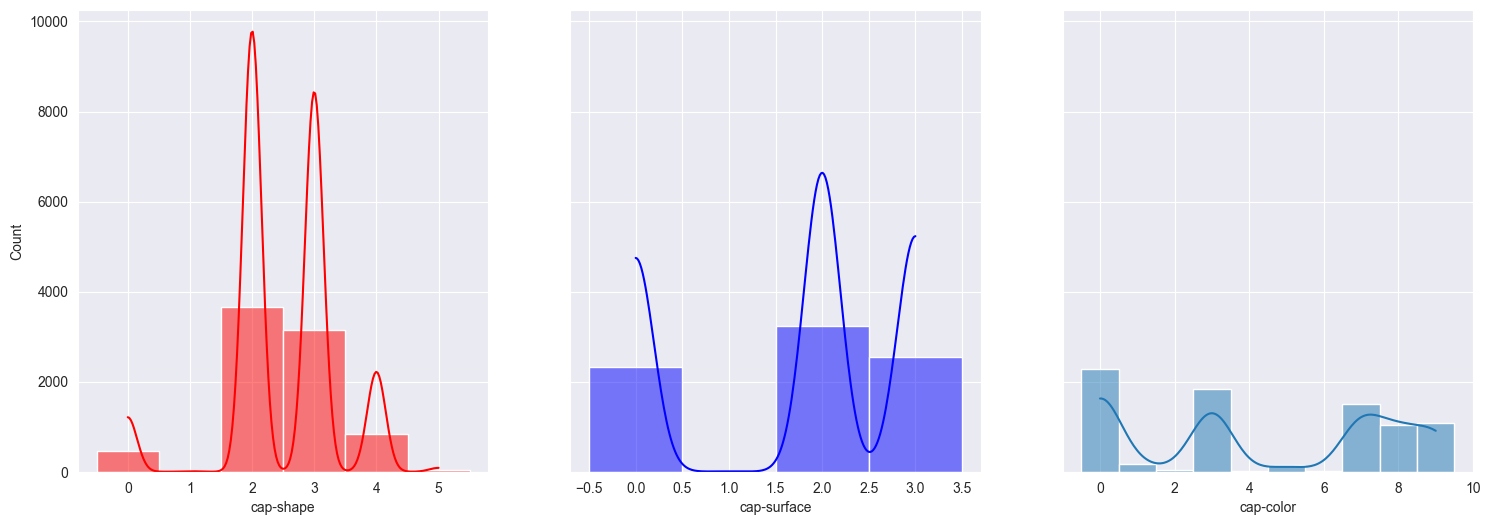

In [10]:
'''
BASIC EDA
'''

# HEAT MAP
M_everything_df["class"].hist()
corr = M_everything_df.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

# FEATURE HISTOGRAMS
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(M_everything_df, ax=axes[0], x="cap-shape", kde=True, color='r')
sns.histplot(M_everything_df, ax=axes[1], x="cap-surface", kde=True, color='b')
sns.histplot(M_everything_df, ax=axes[2], x="cap-color", kde=True)

In [11]:
'''
NAIVE BAYES FUNCTIONS 
'''

def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

def NB_GAUSSIAN(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [12]:
'''
ANALYZE DATA
'''

Y_pred = NB_GAUSSIAN(train, X=X_test, Y="class")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

[[752  93]
 [113 667]]
0.8662337662337662
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       845
           1       0.88      0.86      0.87       780

    accuracy                           0.87      1625
   macro avg       0.87      0.87      0.87      1625
weighted avg       0.87      0.87      0.87      1625

